In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
import os
from collections import defaultdict
from fastai.vision.models.cadene_models import *

### Set up paths

In [2]:
train_pd = pd.read_csv('/root/.fastai/data/severstal/train.csv')

In [3]:
train_pd.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
path = Path('/root/.fastai/data/severstal')

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/severstal/train_images.zip'),
 PosixPath('/root/.fastai/data/severstal/sample_submission.csv'),
 PosixPath('/root/.fastai/data/severstal/test_images.zip'),
 PosixPath('/root/.fastai/data/severstal/train.csv'),
 PosixPath('/root/.fastai/data/severstal/train_images'),
 PosixPath('/root/.fastai/data/severstal/test_images')]

In [6]:
train_images = get_image_files(path/'train_images')
train_images[:3]

[PosixPath('/root/.fastai/data/severstal/train_images/5e581254c.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/fd2f7b4f4.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/82f4c0b69.jpg')]

### Check maximum size of images

In [7]:
def check_img_max_size(folder):
    max_height = 0
    max_width = 0
    for train_image in train_images:
        img = open_image(train_image)
        if max_height < img.shape[1]:
            max_height = img.shape[1]
        if max_width < img.shape[2]:
            max_width = img.shape[2]
    return max_height, max_width

def show_image(images, index):
    img_f = images[index]
    print(type(img_f))
    img = open_image(img_f)
    print(img)
    img.show(figsize=(5,5))

In [8]:
mask_path = Path('/kaggle/mask')
if not os.path.exists(mask_path):
    os.makedirs(str(mask_path))

In [9]:
def convert_encoded_to_array(encoded_pixels):
    pos_array = []
    len_array = []
    splits = encoded_pixels.split()
    pos_array = [int(n) - 1 for i, n in enumerate(splits) if i % 2 == 0]
    len_array = [int(n) for i, n in enumerate(splits) if i % 2 == 1]
    return pos_array, len_array
        
def convert_to_pair(pos_array, rows):
    return [(p % rows, p // rows) for p in pos_array]

def create_positions(single_pos, size):
    return [i for i in range(single_pos, single_pos + size)]

def create_positions_pairs(single_pos, size, row_size):
    return convert_to_pair(create_positions(single_pos, size), row_size)

def convert_to_mask(encoded_pixels, row_size, col_size, category):
    pos_array, len_array = convert_encoded_to_array(encoded_pixels)
    mask = np.zeros([row_size, col_size])
    for(p, l) in zip(pos_array, len_array):
        for row, col in create_positions_pairs(p, l, row_size):
            mask[row][col] = category
    return mask

def save_to_image(masked, image_name):
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    image_name = re.sub(r'(.+)\.jpg', r'\1', image_name) + ".png"
    real_path = mask_path/image_name
    im.save(real_path)
    return real_path

def open_single_image(path):
    img = open_image(path)
    img.show(figsize=(20,20))
    
def get_y_fn(x):
    return mask_path/(x.stem + '.png')

def group_by(train_images, train_pd):
    tran_dict = {image.name:[] for image in train_images}
    pattern = re.compile('(.+)_(\d+)')
    for index, image_path in train_pd.iterrows():
        m = pattern.match(image_path['ImageId_ClassId'])
        file_name = m.group(1)
        category = m.group(2)
        tran_dict[file_name].append((int(category), image_path['EncodedPixels']))
    return tran_dict

def display_image_with_mask(img_name):
    full_image = path/'train_images'/img_name
    print(full_image)
    open_single_image(full_image)
    mask_image = get_y_fn(full_image)
    mask = open_mask(mask_image)
    print(full_image)
    mask.show(figsize=(20, 20), alpha=0.5)

In [10]:
grouped_categories_mask = group_by(train_images, train_pd)

### Create mask files and save these to kaggle/mask/

In [11]:
image_height = 256
image_width = 1600
if not os.path.exists(mask_path/'0002cc93b.png'):
    for image_name, cat_list in grouped_categories_mask.items():
        masked = np.zeros([image_height, image_width])
        for cat_mask in cat_list:
            encoded_pixels = cat_mask[1]
            if pd.notna(cat_mask[1]):
                masked += convert_to_mask(encoded_pixels, image_height, image_width, cat_mask[0])
        if np.amax(masked) > 4:
            print(f'Check {image_name} for max category {np.amax(masked)}')
        save_to_image(masked, image_name)

### Prepare Transforms

In [12]:
def limited_dihedral_affine(k:partial(uniform_int,0,3)):
    "Randomly flip `x` image based on `k`."
    x = -1 if k&1 else 1
    y = -1 if k&2 else 1
    if k&4: return [[0, x, 0.],
                    [y, 0, 0],
                    [0, 0, 1.]]
    return [[x, 0, 0.],
            [0, y, 0],
            [0, 0, 1.]]

dihedral_affine = TfmAffine(limited_dihedral_affine)

def get_extra_transforms(max_rotate:float=3., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    p_lightings = [p_lighting, p_lighting + 0.2, p_lighting + 0.4, p_lighting + 0.6, p_lighting + 0.7]
    max_lightings = [max_lighting, max_lighting + 0.2, max_lighting + 0.4, max_lighting + 0.6, max_lighting + 0.7]
    res = [rand_crop(), dihedral_affine(), 
           symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine),
           rotate(degrees=(-max_rotate,max_rotate), p=p_affine),
           rand_zoom(scale=(1., max_zoom), p=p_affine)]
    res.extend([brightness(change=(0.5*(1-mp[0]), 0.5*(1+mp[0])), p=mp[1]) for mp in zip(max_lightings, p_lightings)])
    res.extend([contrast(scale=(1-mp[0], 1/(1-mp[0])), p=mp[1]) for mp in zip(max_lightings, p_lightings)])
    #       train                   , valid
    return (res, [crop_pad()])

def get_simple_transforms(max_rotate:float=3., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [
        rand_crop(),
        symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine),
        rotate(degrees=(-max_rotate,max_rotate), p=p_affine),
        rand_zoom(scale=(1., max_zoom), p=p_affine)
          ]
    #       train                   , valid
    return (res, [crop_pad()])

### Prepare data bunch

In [13]:
train_images = (path/'train_images').ls()
src_size = np.array(open_image(str(train_images[0])).shape[1:])
valid_pct = 0.10

In [14]:
codes = array(['0', '1', '2', '3', '4'])

In [15]:
def create_data_bunch(bs, size):
    src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct(valid_pct=valid_pct)
       .label_from_func(get_y_fn, classes=codes))
    data = (src.transform(get_simple_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
    return src, data

In [16]:
bs = 4
size = src_size//2
src, data = create_data_bunch(bs, size)

### Create learner and training
Starting with low resolution training

##### Some metrics functions

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    argmax = (input.argmax(dim=1))
    comparison = argmax[mask]==target[mask]
    return torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()

def acc_camvid_with_zero_check(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        if(torch.sum(argmax[b]).item() == 0.0 and torch.sum(target[b]).item() == 0.0):
            total[b] = 1
        else:
            mask = target[b] != void_code
            comparison = argmax[b][mask]==target[b][mask]
            total[b] = torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()
    return total.mean()


def calc_dice_coefficients(argmax, target, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.float())
        sum_gt = torch.sum(mask_gt.float())
        if sum_seg + sum_gt == 0:
            return torch.tensor(1.0)
        return (torch.sum((seg[gt == cat] / cat).float()) * 2.0) / (sum_seg + sum_gt)

    total_avg = torch.empty([len(cats)])
    for i, c in enumerate(cats):
        total_avg[i] = calc_dice_coefficient(argmax, target, c)
    return total_avg.mean()


def dice_coefficient(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        total[b] = calc_dice_coefficients(argmax[b], target[b], cats)
    return total.mean()

def calc_dice_coefficients_2(argmax, target, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.float())
        sum_gt = torch.sum(mask_gt.float())
        return (torch.sum((seg[gt == cat] / cat).float())), (sum_seg + sum_gt)

    total_avg = torch.empty([len(cats), 2])
    for i, c in enumerate(cats):
        total_avg[i][0], total_avg[i][1] = calc_dice_coefficient(argmax, target, c)
    total_sum = total_avg.sum(axis=0)
    if (total_sum[1] == 0.0):
        return torch.tensor(1.0)
    return total_sum[0] * 2.0 / total_sum[1]


def dice_coefficient_2(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        total[b] = calc_dice_coefficients_2(argmax[b], target[b], cats)
    return total.mean()


def accuracy_simple(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

### Customized loss function

In [18]:
class CombinedDiceLoss(nn.Module):
    def __init__(self, zero_cat_factor=0.1):
        super().__init__()
        self.zero_cat_factor = zero_cat_factor

    def forward(self, input, target):
        return self.dice_loss(target, input, self.zero_cat_factor)

    def dice_loss(self, target, output, eps=1e-7, zero_cat_factor=0.1):
        '''
        Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
        Assumes the `channels_last` format.

        # Arguments
            target: b x 1 x X x Y( x Z...) ground truth
            output: b x c x X x Y( x Z...) Network output, must sum to 1 over c channel (such as after softmax)
            epsilon: Used for numerical stability to avoid divide by zero errors

        # References
            V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation
            https://arxiv.org/abs/1606.04797
            More details on Dice loss formulation
            https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)

            Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
        '''

        # skip the batch and class axis for calculating Dice score
        num_classes = output.shape[1]
        y_true = F.one_hot(target.long().squeeze(), num_classes)
        y_pred = F.softmax(output, dim=1).permute(0, 2, 3, 1)
        y_true = y_true.type(y_pred.type())
        y_true = y_true.permute(0, 3, 1, 2)
        y_true[:,0,:] *= zero_cat_factor # Factor used to take power away from the zeroth category
        y_true = y_true.permute(0, 2, 3, 1)
        axes = tuple(range(1, len(y_pred.shape)-1))
        numerator = 2. * torch.sum(y_pred * y_true, axes)
        denominator = torch.sum(y_pred ** 2 + y_true ** 2, axes)
        # When intersection and cardinality are all zero you have 100% score and not 0% score
        # For this we use the eps parameter
        loss_array = ((numerator + eps) / (denominator + eps))
        loss_array = (loss_array).mean(dim=0)
        return ((1 - torch.mean(loss_array)) + F.cross_entropy(output, target.squeeze())) / 2.

    def __del__(self): pass

##### The main training function

In [19]:
from fastai import callbacks

def train_learner(learn, slice_lr, epochs=10, pct_start=0.8, best_model_name='best_model', 
                  patience_early_stop=4, patience_reduce_lr = 3):
    learn.fit_one_cycle(epochs, slice_lr, pct_start=pct_start, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name=best_model_name),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=patience_early_stop),
                              callbacks.ReduceLROnPlateauCallback(learn=learn, monitor='dice_coefficient', patience=patience_reduce_lr),
                              callbacks.TerminateOnNaNCallback()])

### First Training

In [20]:
metrics=accuracy_simple, acc_camvid_with_zero_check, dice_coefficient, dice_coefficient_2
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
# learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0, .5, .5, .5, .5]).cuda())
learn.loss_func = CombinedDiceLoss(zero_cat_factor=0.5)
learn.loss_func

CombinedDiceLoss()

In [22]:
learn.model_dir = Path('/kaggle/model')

In [23]:
# learn = to_fp16(learn, loss_scale=4.0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


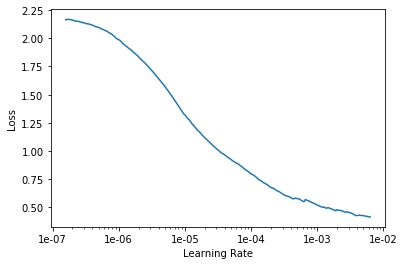

In [24]:
lr_find(learn, num_it=400)
learn.recorder.plot()

In [25]:
lr=1e-04

In [26]:
train_learner(learn, slice(lr), epochs=10, pct_start=0.8, best_model_name='bestmodel-frozen-1', 
              patience_early_stop=4, patience_reduce_lr = 3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time
0,0.210704,0.203583,0.974005,0.556441,0.877445,0.564374,05:16
1,0.204501,0.201876,0.974453,0.540219,0.880200,0.571359,05:16
2,0.217851,0.180933,0.977930,0.567265,0.885530,0.608430,05:17
3,0.187363,0.181227,0.977313,0.566786,0.886843,0.615561,05:17
4,0.186578,0.169047,0.979720,0.630603,0.899377,0.649751,05:23
5,0.193060,0.158909,0.980248,0.675486,0.909994,0.689128,05:23
6,0.165434,0.161674,0.980629,0.688209,0.915096,0.705524,05:23
7,0.178435,0.159382,0.980107,0.668919,0.903398,0.686789,05:24
8,0.163246,0.155871,0.980304,0.688581,0.911034,0.694085,05:22
9,0.156271,0.148171,0.981584,0.715938,0.921352,0.725638,05:22


Better model found at epoch 0 with dice_coefficient value: 0.8774449229240417.
Better model found at epoch 1 with dice_coefficient value: 0.8802003264427185.
Better model found at epoch 2 with dice_coefficient value: 0.8855295181274414.
Better model found at epoch 3 with dice_coefficient value: 0.8868431448936462.
Better model found at epoch 4 with dice_coefficient value: 0.8993771076202393.
Better model found at epoch 5 with dice_coefficient value: 0.9099943041801453.
Better model found at epoch 6 with dice_coefficient value: 0.91509610414505.
Better model found at epoch 9 with dice_coefficient value: 0.9213515520095825.


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

In [ ]:
learn.load('bestmodel-frozen-1');

In [29]:
learn.export(file='/kaggle/model/export-1.pkl')

/opt/conda/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CombinedDiceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/100,lr)

In [32]:
train_learner(learn, lrs, epochs=10, pct_start=0.8, best_model_name='bestmodel-unfrozen-1', 
              patience_early_stop=4, patience_reduce_lr = 3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time
0,0.163928,0.148662,0.981743,0.720051,0.919637,0.724050,05:52
1,0.158752,0.146669,0.981914,0.716869,0.922488,0.732964,05:53
2,0.155523,0.148330,0.980853,0.741496,0.921275,0.725375,05:51
3,0.165156,0.146465,0.981966,0.705554,0.915786,0.717604,05:54
4,0.149147,0.150821,0.980260,0.723218,0.918364,0.712595,05:44
5,0.154772,0.148231,0.980182,0.751208,0.923175,0.730273,05:41
6,0.158132,0.149820,0.981884,0.706415,0.917149,0.713693,05:40
7,0.151295,0.144460,0.982041,0.736426,0.927686,0.744796,05:40
8,0.140953,0.141040,0.982625,0.743231,0.922104,0.733332,05:42
9,0.141663,0.137530,0.983165,0.766649,0.928940,0.758719,05:41


Better model found at epoch 0 with dice_coefficient value: 0.9196370244026184.
Better model found at epoch 1 with dice_coefficient value: 0.9224876165390015.
Better model found at epoch 5 with dice_coefficient value: 0.923175036907196.
Better model found at epoch 7 with dice_coefficient value: 0.9276857972145081.
Better model found at epoch 9 with dice_coefficient value: 0.9289398193359375.


In [33]:
learn.save('stage-2');

In [34]:
learn.load('stage-2');

In [35]:
learn.export(file='/kaggle/model/export-2.pkl')

### Go Large

In [36]:
learn=None
gc.collect()

40

In [21]:
bs=4

In [22]:
def create_large_learner(bs=4, size=size, transform_func=get_simple_transforms, model_to_load='bestmodel-unfrozen-1'):
    data = (src.transform(transform_func(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
    learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
    learn.model_dir = Path('/kaggle/model')
    learn.loss_func = CombinedDiceLoss(zero_cat_factor=0.5)
#     learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([1.5, .5, .5, .5, .5]).cuda())
#     learn = to_fp16(learn, loss_scale=8.0)
    if model_to_load is not None:
        learn.load(model_to_load)
    return learn

In [23]:
learn = create_large_learner(bs=bs, size=src_size, transform_func=get_simple_transforms, model_to_load='bestmodel-unfrozen-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


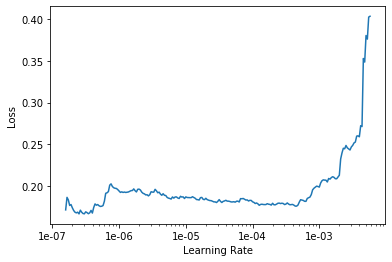

In [24]:
lr_find(learn, num_it=400)
learn.recorder.plot()

In [25]:
lr=1e-04

In [ ]:
train_learner(learn, slice(lr), epochs=10, pct_start=0.8, best_model_name='bestmodel-frozen-3', 
              patience_early_stop=4, patience_reduce_lr = 3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time


In [27]:
learn.save('stage-3');

In [28]:
learn.load('bestmodel-frozen-3');

In [29]:
learn.export(file='/kaggle/model/export-3.pkl')

/opt/conda/envs/deeplearning/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CombinedDiceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [31]:
learn.unfreeze()

In [32]:
lrs = slice(lr/1000,lr/10)

In [33]:
train_learner(learn, lrs, epochs=10, pct_start=0.8, best_model_name='bestmodel-4', 
              patience_early_stop=5, patience_reduce_lr = 3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,dice_coefficient_2,time
0,0.155961,0.145340,0.980400,0.734930,0.921745,0.721175,05:41
1,0.149046,0.140909,0.982022,0.738009,0.925075,0.740396,05:39
2,0.143460,0.137951,0.982658,0.747147,0.929874,0.755609,05:40


Better model found at epoch 0 with dice_coefficient value: 0.9217453598976135.
Better model found at epoch 1 with dice_coefficient value: 0.925074577331543.
Better model found at epoch 2 with dice_coefficient value: 0.929873526096344.


KeyboardInterrupt: 

In [ ]:
learn.save('stage-4');

In [ ]:
learn.load('bestmodel-4');

In [ ]:
learn.export(file='/kaggle/model/export-4.pkl')

In [ ]:
!pwd
!cp /kaggle/model/export.pkl /opt/fastai/fastai-exercises/nbs_gil
from IPython.display import FileLink
FileLink(r'export-4.pkl')

### Inference

In [ ]:
learn=None
gc.collect()

In [ ]:
test_images = (path/'test_images').ls()

In [ ]:
inference_learn = load_learner('/kaggle/model/', file='export-2.pkl')

In [ ]:
inference_learn = to_fp16(inference_learn, loss_scale=4.0)

In [ ]:
def predict(img_path):
    pred_class, pred_idx, outputs = inference_learn.predict(open_image(str(img_path)))
    return pred_class, pred_idx, outputs

def encode_classes(pred_class_data):
    pixels = np.concatenate([[0], torch.transpose(pred_class_data.squeeze(), 0, 1).flatten(), [0]])
    classes_dict = {1: [], 2: [], 3: [], 4: []}
    count = 0
    previous = pixels[0]
    for i, val in enumerate(pixels):
        if val != previous:
            if previous in classes_dict:
                classes_dict[previous].append((i - count, count))
            count = 0
        previous = val
        count += 1
    return classes_dict


def convert_classes_to_text(classes_dict, clazz):
    return ' '.join([f'{v[0]} {v[1]}' for v in classes_dict[clazz]])

In [ ]:
image_to_predict = train_images[16].name
display_image_with_mask(image_to_predict)
pred_class, pred_idx, outputs = predict(path/f'train_images/{image_to_predict}')
pred_class

In [ ]:
torch.transpose(pred_class.data.squeeze(), 0, 1).shape

#### Checking encoding methods

In [ ]:
encoded_all = encode_classes(pred_class.data)
print(convert_classes_to_text(encoded_all, 3))

In [ ]:
image_name = train_images[16]
print(get_y_fn(image_name))
img = open_mask(get_y_fn(image_name))
img_data = img.data
print(convert_classes_to_text(encode_classes(img_data), 3))
img_data.shape

### Loop through the test images and create submission csv

In [ ]:
import time
start_time = time.time()

defect_classes = [1, 2, 3, 4]
with open('submission.csv', 'w') as submission_file:
    submission_file.write('ImageId_ClassId,EncodedPixels\n')
    for i, test_image in enumerate(test_images):
        pred_class, pred_idx, outputs = predict(test_image)
        encoded_all = encode_classes(pred_class.data)
        for defect_class in defect_classes:
            submission_file.write(f'{test_image.name}_{defect_class},{convert_classes_to_text(encoded_all, defect_class)}\n')
        if i % 5 == 0:
            print(f'Processed {i} images\r', end='')
            
print(f"--- {time.time() - start_time} seconds ---")

### Alternative prediction methods

In [ ]:
preds,y = learn.get_preds(ds_type=DatasetType.Test, with_loss=False)

In [ ]:
preds.shape

In [ ]:
pred_class_data = preds.argmax(dim=1)

In [ ]:
len((path/'test_images').ls())

In [ ]:
data.test_ds.x